# 准备工作

In [7]:
suppressMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(ggrepel)
    library(UpSetR)
    library(pheatmap)
    library(grid)
    library(RColorBrewer)
    library(viridis)
    library(UpSetR)
})

In [8]:
root <- ""### FILL THIS IN

source(paste0(root,"crispr_utils.R"))
source(paste0(root,"chirp_utils.R"))

In [9]:
crispr_root <- paste0(root,"crispr/")
crispr_outputs <- paste0(crispr_root,"outputs/")
if (!dir.exists(crispr_outputs)) dir.create(crispr_outputs)

# Crispr RNA 分析

In [10]:
e_counts <- read.delim(paste0(crispr_root,"exp_counts_table.tsv"),stringsAsFactors=F)
m_counts <- read.delim(paste0(crispr_root,"mito_counts_table.tsv"),stringsAsFactors=F)

In [11]:
sig_t <- 0.001

e_all <- normalize_counts(e_counts)
e_merged <- guide_zscores(create_condition_list(e_all,merge_reps = T))
e_nomerge <- guide_zscores(create_condition_list(e_all,merge_reps = F))
e_genes <- gene_zscores(e_merged)

ez_genes <- create_zscore_table(e_genes,mb="Gene")

m_all <- normalize_counts(m_counts)
m_merged <- guide_zscores(create_condition_list(m_all,merge_reps = T))
m_nomerge <- guide_zscores(create_condition_list(m_all,merge_reps = F))
m_genes <- gene_zscores(m_merged)

mz_genes <- create_zscore_table(m_genes,mb="Gene")

e_reps_gene_zscore <- create_zscore_table(gene_zscores(e_nomerge),mb = "Gene")
m_reps_gene_zscore <- create_zscore_table(gene_zscores(m_nomerge),mb = "Gene")

## pca

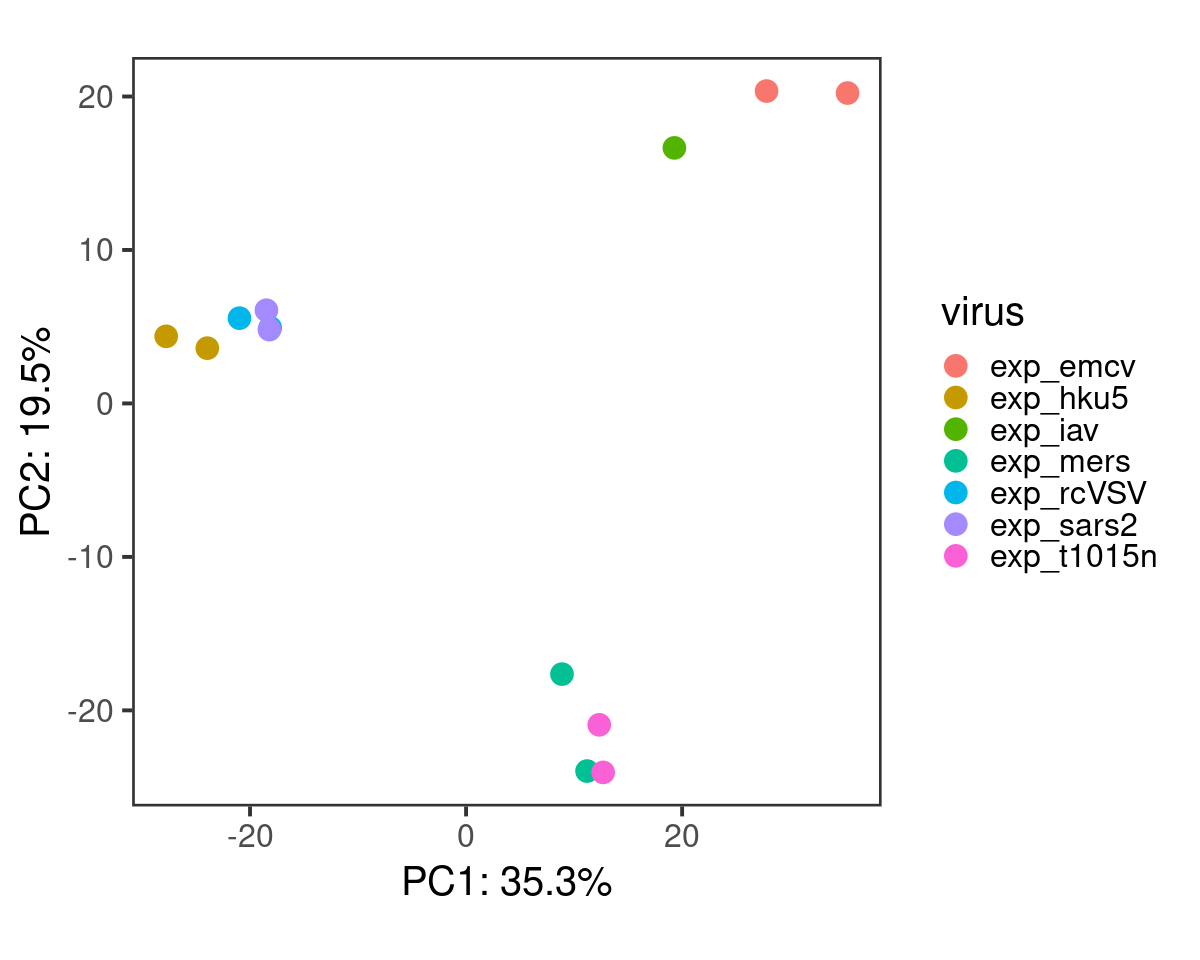

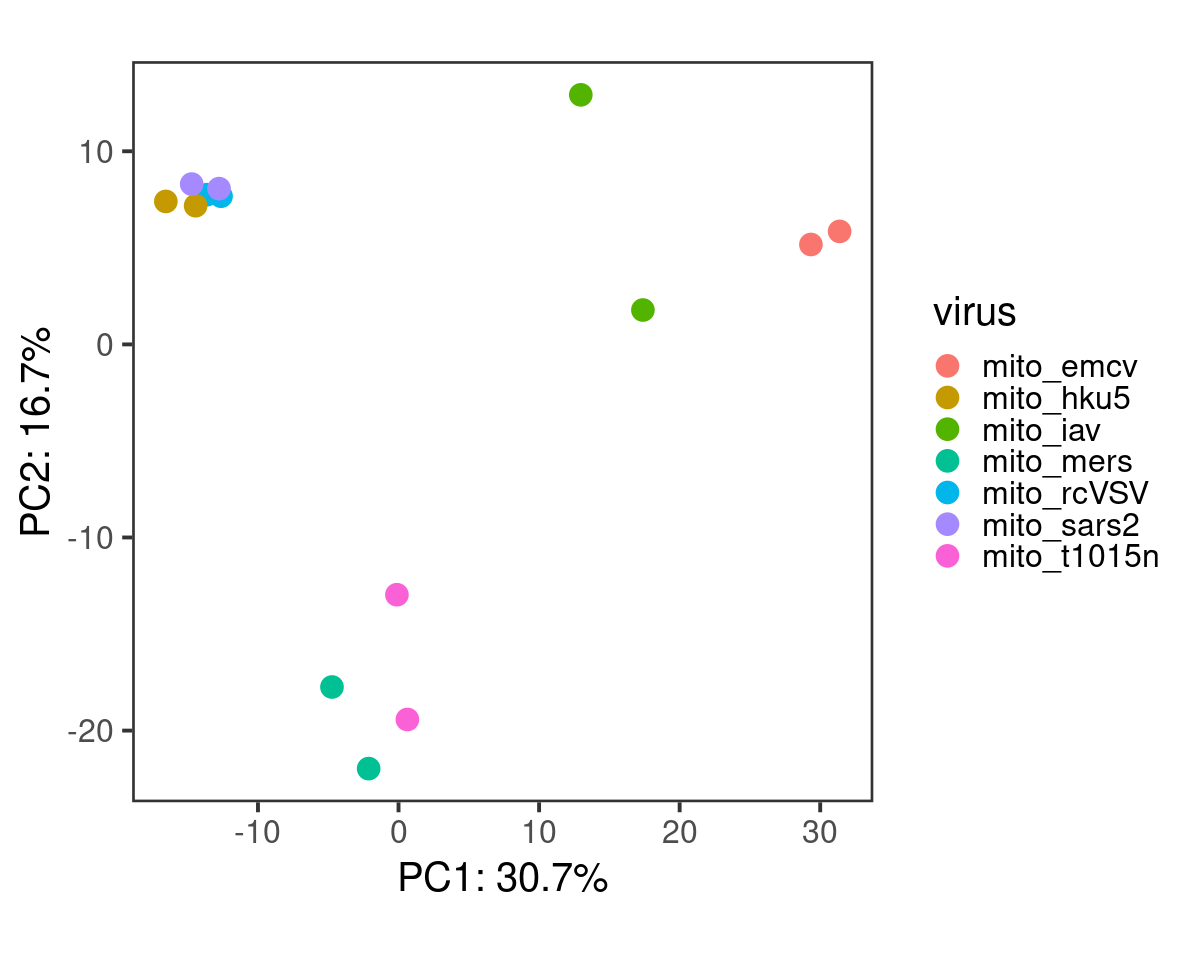

In [12]:
ez <- e_reps_gene_zscore[,which(endsWith(colnames(e_reps_gene_zscore),"_z"))]
mz <- m_reps_gene_zscore[,which(endsWith(colnames(m_reps_gene_zscore),"_z"))]

pca_plt(ez,nm="exp-pool-reps",group1="virus",offset=4,corrout = crispr_outputs)
pca_plt(mz,nm="mito-pool-reps",group1="virus",offset=4,corrout = crispr_outputs)

In [13]:
ez[1:4, ]

,exp_rcVSV_1_z,exp_rcVSV_2_z,exp_hku5_1_z,exp_hku5_2_z,exp_sars2_1_z,exp_sars2_2_z,exp_mers_1_z,exp_mers_2_z,exp_t1015n_1_z,exp_t1015n_2_z,exp_emcv_1_z,exp_emcv_2_z,exp_iav_1_z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.4000519,1.4132746,1.360893,2.0381105,0.6128498,-0.535137,-0.36890342,0.07590343,0.4051932,0.9768029,-4.951257,1.814421,0.2412441
2,-2.1475021,0.5028531,-4.868497,2.1426784,-1.3006855,-0.578169,-3.69921414,-3.58958872,-2.1219597,-4.8604439,-3.333830,-4.853630,-3.1791008
3,-0.4454518,-5.9275255,-1.158265,-0.5151849,-0.8208148,-3.652614,-3.43208463,-5.62781201,-6.9873076,-8.1866644,-7.416124,-8.603951,-4.9367722
4,-1.2696909,-0.1796289,4.111166,-1.0497403,-2.0716252,-2.833436,0.04451444,0.73361456,0.7998000,2.5044159,-4.166028,-4.140146,-2.6062540


In [14]:
mz[1:4, ]

,mito_rcVSV_1_z,mito_rcVSV_2_z,mito_hku5_1_z,mito_hku5_2_z,mito_sars2_1_z,mito_sars2_2_z,mito_mers_1_z,mito_mers_2_z,mito_t1015n_1_z,mito_t1015n_2_z,mito_emcv_1_z,mito_emcv_2_z,mito_iav_1_z,mito_iav_2_z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.9262068,-3.291562,-1.3789781,-1.0587169,-3.8936856,-2.8679952,-2.8149863,-0.08378803,0.1307906,-0.5058343,-3.718322,-7.686680,-1.7763162,-7.240775
2,-1.0750616,1.754143,3.9748559,-0.7136303,-1.3870883,-0.9976539,-2.7615654,-3.85356573,-5.2183090,-2.8977832,-6.569177,-7.280177,-15.3738159,-5.495913
3,2.8077249,4.048145,-0.9588973,2.8180019,2.4302361,0.8029931,0.8200284,0.14495495,-0.4515227,0.6594748,-5.584571,-6.582017,0.9481442,-1.774954
4,-0.3301597,-1.518146,1.7672712,-0.3948249,-0.6254311,-0.9403695,0.6250618,4.61139526,-0.2919384,-1.2128229,-3.069464,-2.952320,6.2624573,-3.463707


## 画图

In [45]:
proviral <- list()
antiviral <- list()

for (v in names(e_genes)) {
    e_genes[[v]] <- e_genes[[v]] %>% arrange(z)
    antiviral[[v]] <- e_genes[[v]]$Gene[which(e_genes[[v]]$z < 0 & e_genes[[v]]$fdr <= sig_t)]
    e_genes[[v]] <- e_genes[[v]] %>% arrange(desc(z))
    proviral[[v]] <- e_genes[[v]]$Gene[which(e_genes[[v]]$z > 0 & e_genes[[v]]$fdr <= sig_t)] 
}

for (v in names(m_genes)) {
    m_genes[[v]] <- m_genes[[v]] %>% arrange(z)
    antiviral[[v]] <- m_genes[[v]]$Gene[which(m_genes[[v]]$z < 0 & m_genes[[v]]$fdr <= sig_t)]
    m_genes[[v]] <- m_genes[[v]] %>% arrange(desc(z))
    proviral[[v]] <- m_genes[[v]]$Gene[which(m_genes[[v]]$z > 0 & m_genes[[v]]$fdr <= sig_t)] 
}


Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


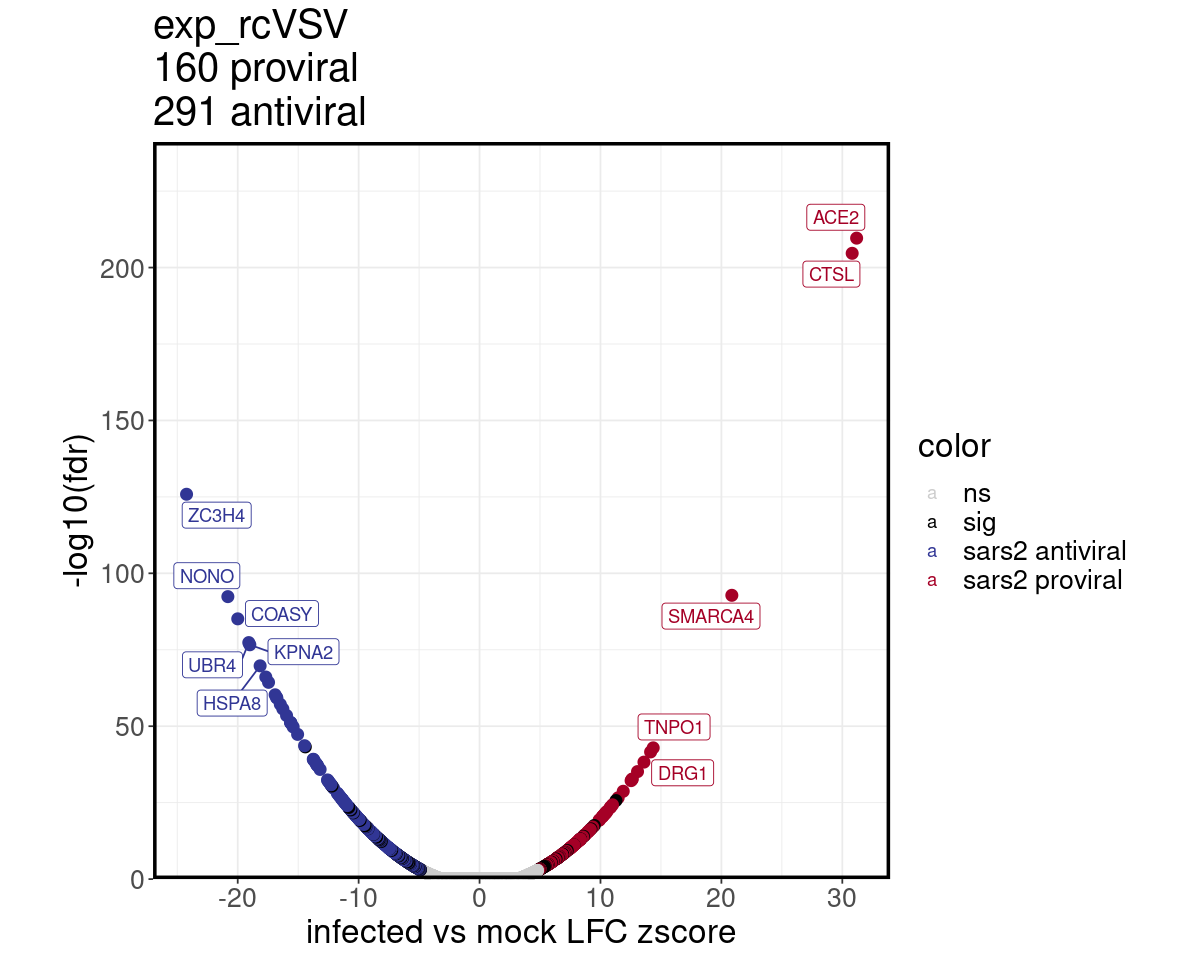

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


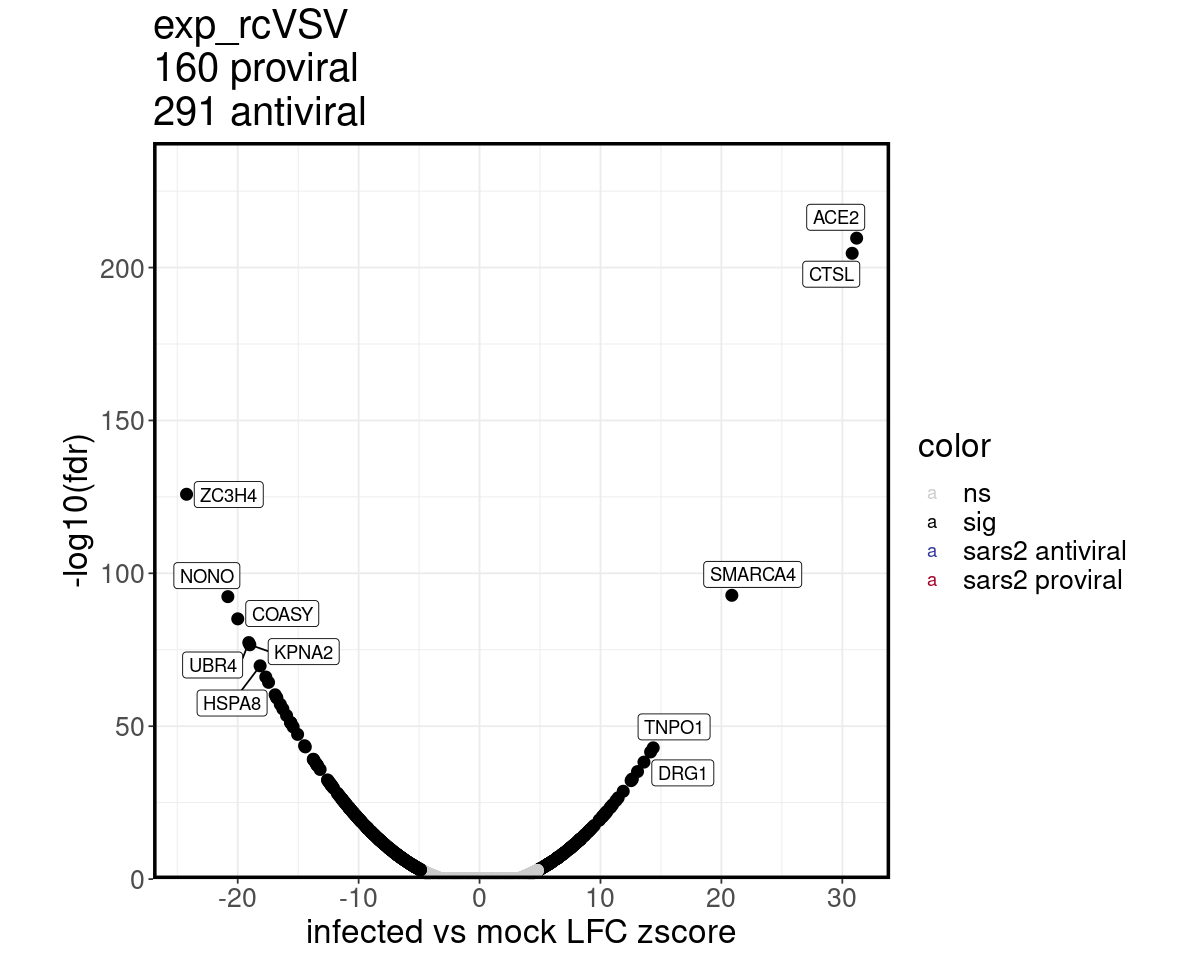

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


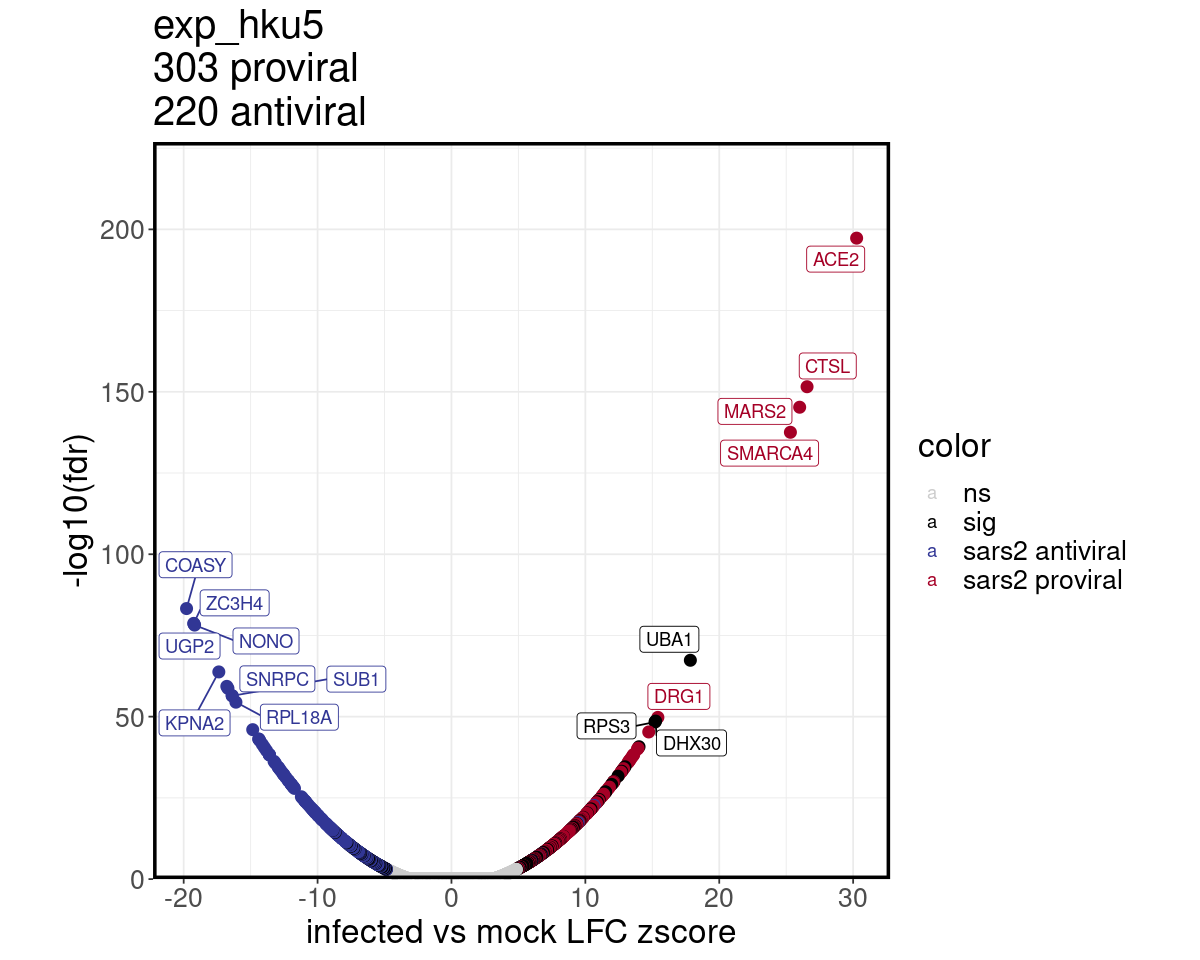

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


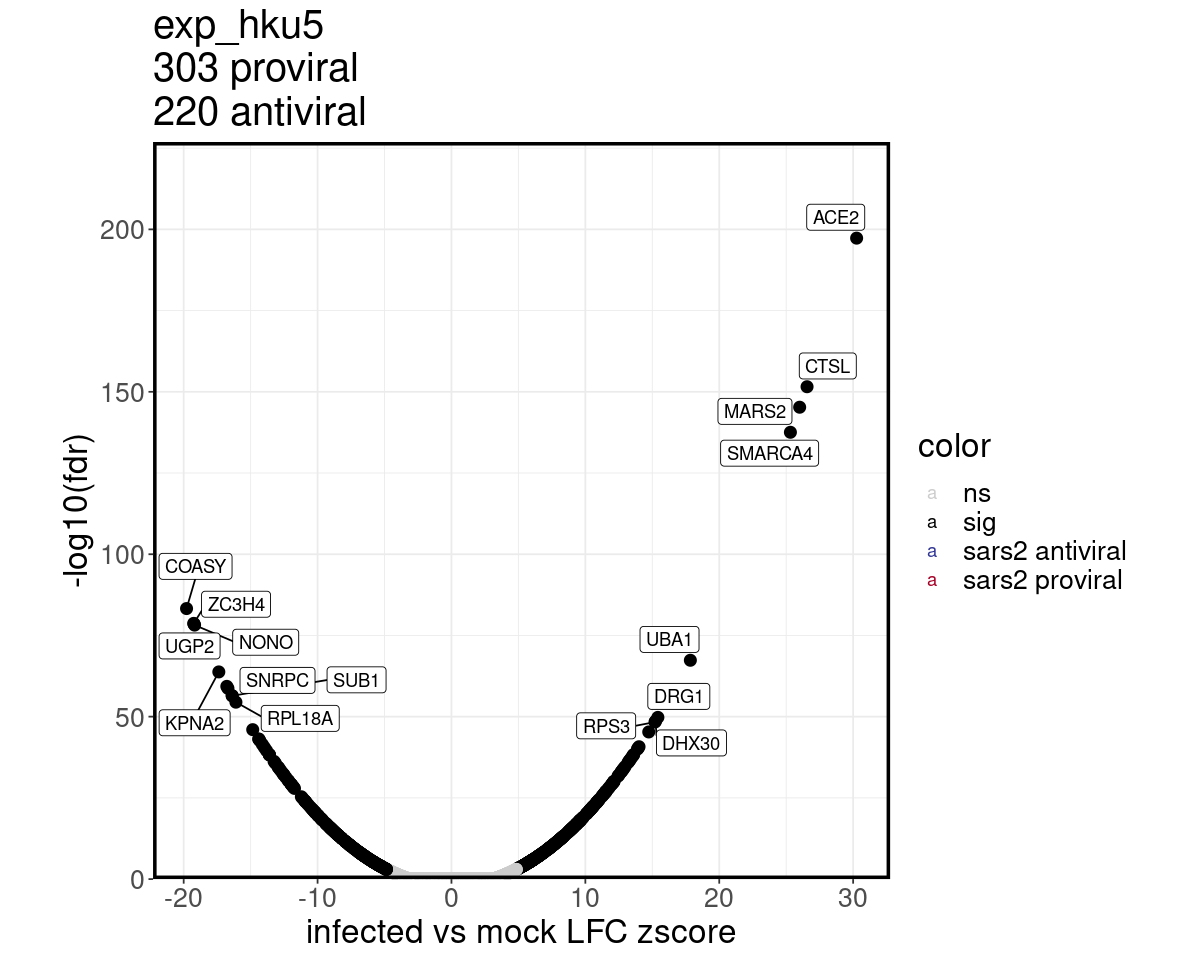

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


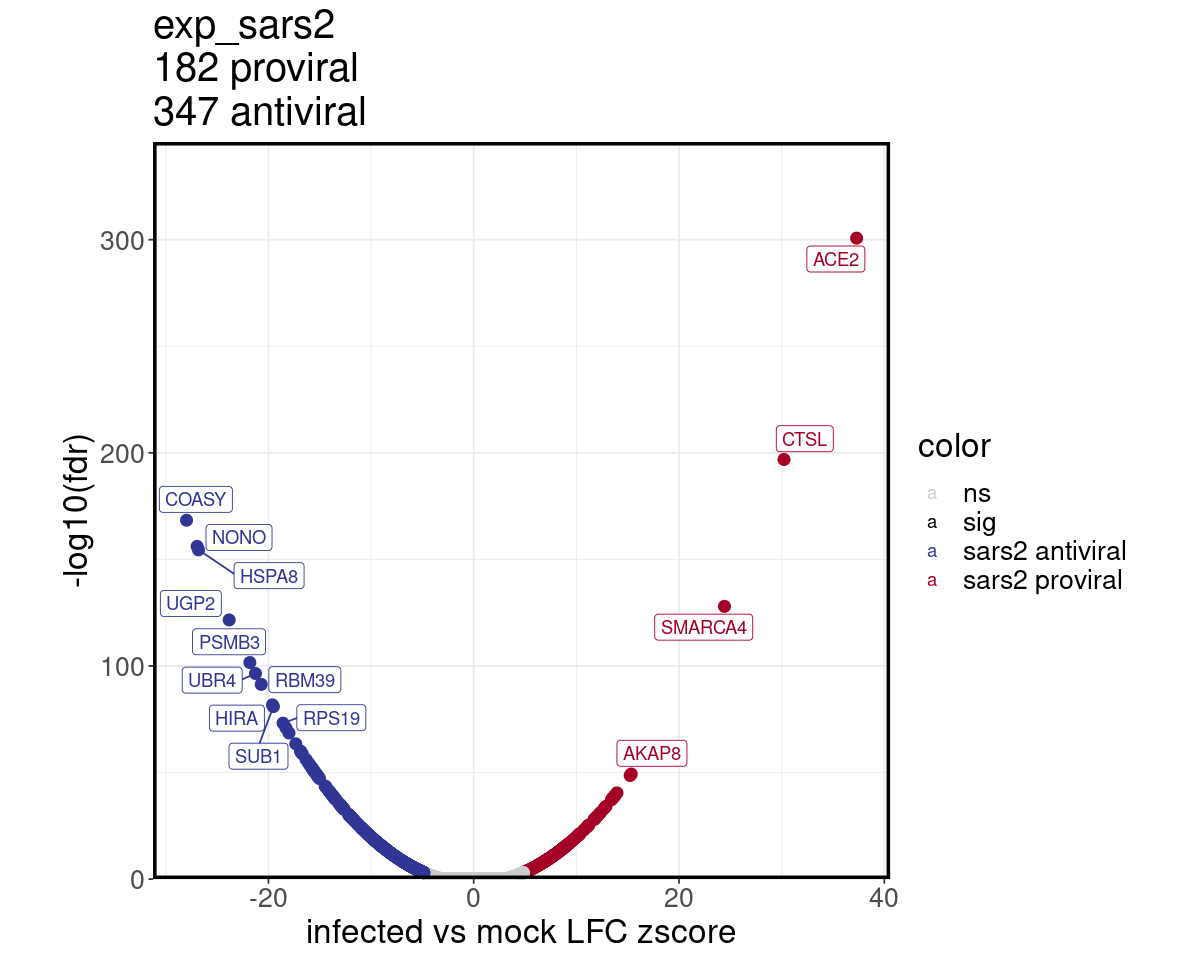

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


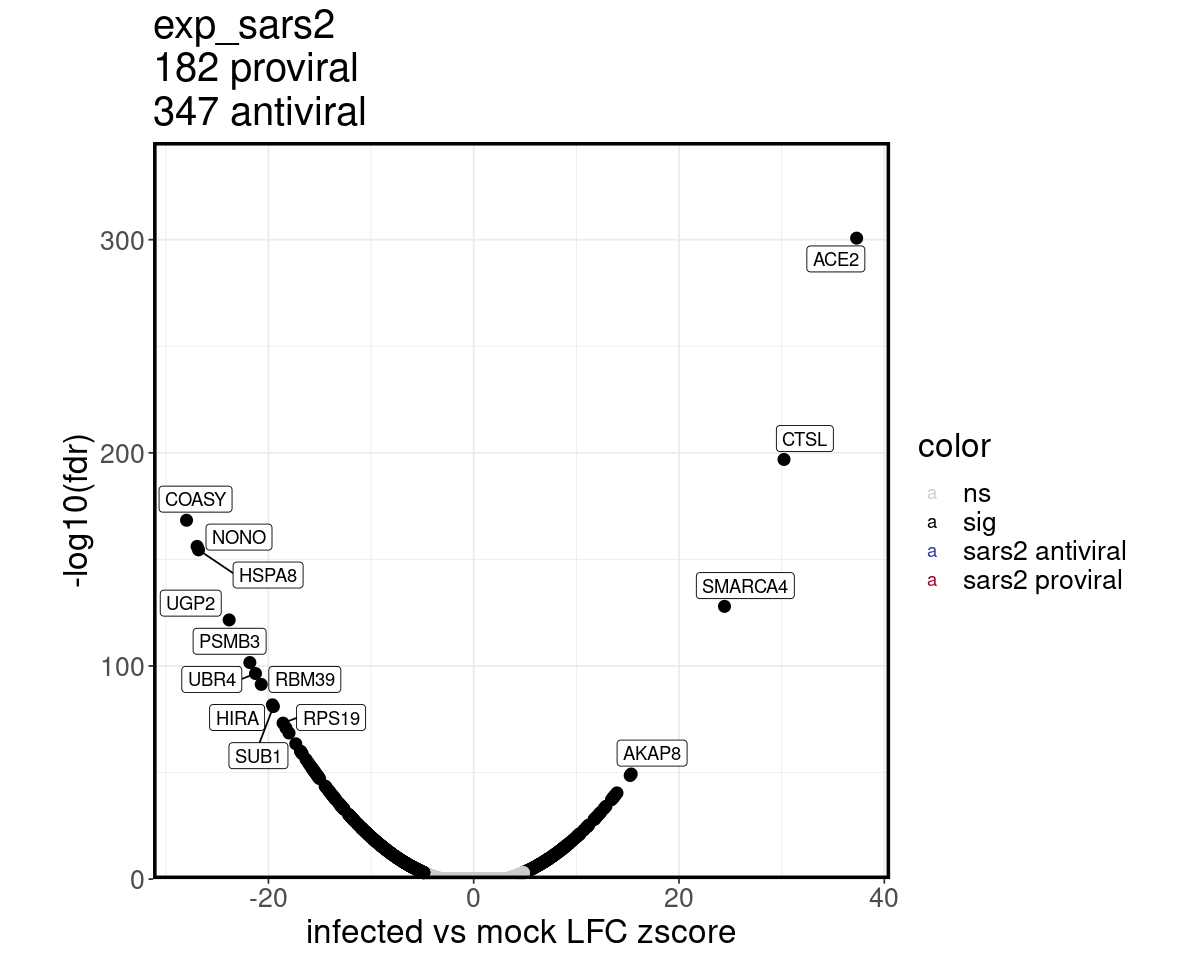

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


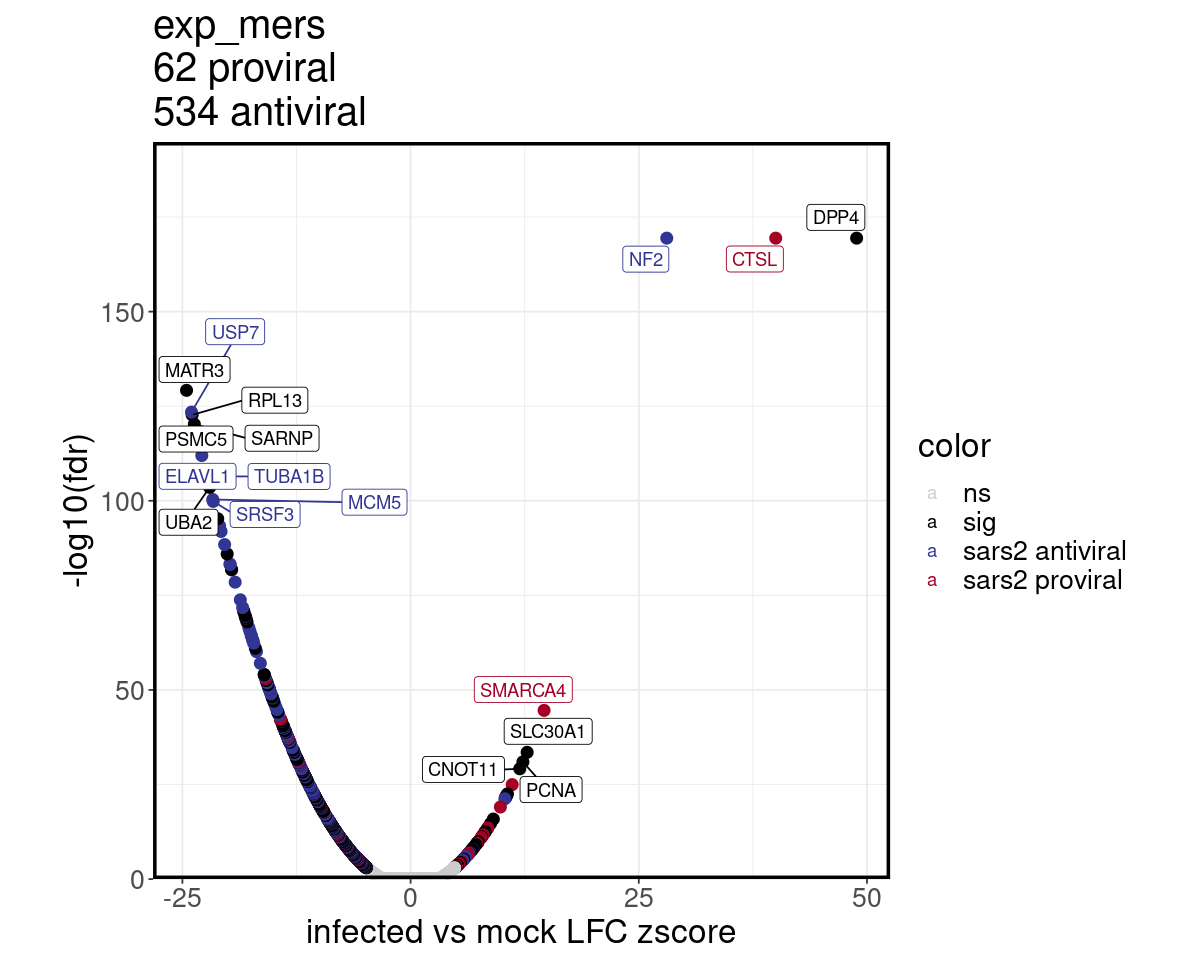

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


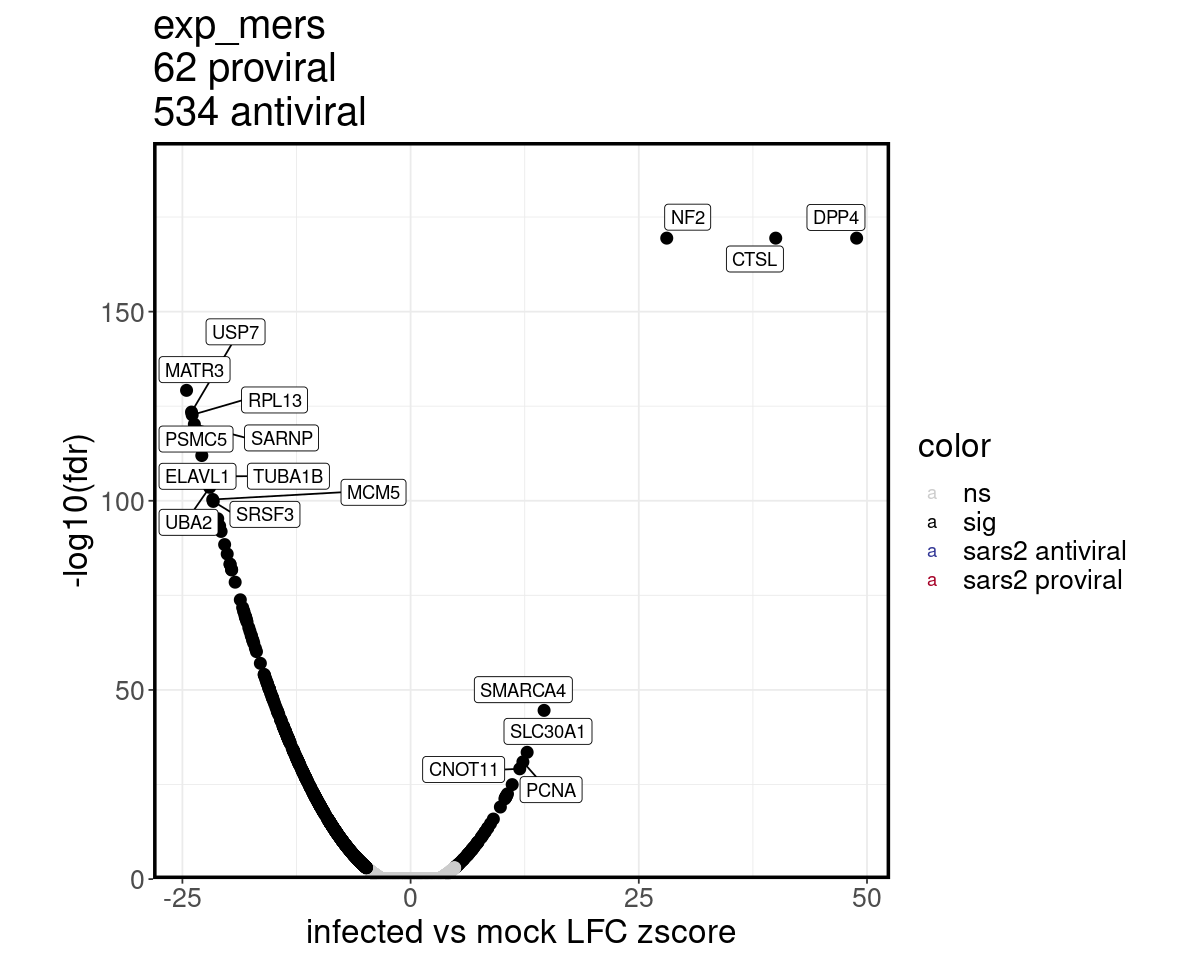

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [46]:
pv <- "exp_sars2"

results <- e_genes

for (virus in names(results)) {
    plt <- crispr_volcano(results[[virus]],virus,c1=antiviral[[pv]],c2=proviral[[pv]],sig_t=sig_t)
    print(plt)
    ggsave(paste0(crispr_outputs,virus,"-sars2-colored-001.eps"),plt)
    plt <- crispr_volcano(results[[virus]],virus,sig_t=sig_t)
    print(plt)
    ggsave(paste0(crispr_outputs,virus,"-001.eps"),plt)
}

In [ ]:
pv <- "mito_sars2"

results <- m_genes

for (virus in names(results)) {
    plt <- crispr_volcano(results[[virus]],virus,c1=antiviral[[pv]],c2=proviral[[pv]],sig_t=sig_t)
    print(plt)
    ggsave(paste0(crispr_outputs,virus,"-sars2-colored-001.eps"),plt)
    plt <- crispr_volcano(results[[virus]],virus,sig_t=sig_t)
    print(plt)
    ggsave(paste0(crispr_outputs,virus,"-001.eps"),plt)
}

# Chirp-MS 分析


## 数据预处理

In [33]:
chirp_root <- paste0(root,"chirp/")
chirp_outputs <- paste0(chirp_root,"outputs/")
if (!dir.exists(chirp_outputs)) dir.create(chirp_outputs)

In [34]:
huh_data_raw <- read.table(paste0(chirp_root,"200814_ChIRP-All_Log2_Imput.txt"),
                       sep="\t",header = TRUE,stringsAsFactors=FALSE)
huh_data_raw$uniprot <- unlist(lapply(huh_data_raw$Majority.protein.IDs,parse_uniprot))
huh_data_raw$species <- unlist(lapply(huh_data_raw$Majority.protein.IDs,parse_species))

vero_data_raw <- read.table(paste0(chirp_root,"Vero_Log2_Imput.txt"),
                       sep="\t",header = TRUE,stringsAsFactors=FALSE)
vero_data_raw$uniprot <- unlist(lapply(vero_data_raw$Majority.protein.IDs,parse_uniprot))
vero_data_raw$species <- unlist(lapply(vero_data_raw$Majority.protein.IDs,parse_species))

In [35]:
huh_data_raw[1:4,]

,Only.identified.by.site,Reverse,Potential.contaminant,Peptides,Razor...unique.peptides,Unique.peptides,Sequence.coverage....,Unique...razor.sequence.coverage....,Unique.sequence.coverage....,Mol..weight..kDa.,⋯,LFQ.intensity.Mock3,LFQ.intensity.RV,LFQ.intensity.RV_C,LFQ.intensity.ZV1,LFQ.intensity.ZV2,LFQ.intensity.ZV3,Protein.IDs,Majority.protein.IDs,uniprot,species
,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,,NA,NA,1,1,1,9.5,9.5,9.5,12.769,⋯,13.05427,17.91911,13.52525,15.36840,16.00725,15.47697,sp|P01767|HV353_HUMAN;sp|A0A0C4DH42|HV366_HUMAN;tr|A0A0J9YY99|A0A0J9YY99_HUMAN;tr|A0A075B7E8|A0A075B7E8_HUMAN;tr|A0A075B7B8|A0A075B7B8_HUMAN;sp|P0DP03|HVC05_HUMAN;sp|P0DP02|HVC33_HUMAN;sp|P01772|HV333_HUMAN;sp|P01768|HV330_HUMAN;sp|P01764|HV323_HUMAN;sp|A0A0B4J1X5|HV374_HUMAN,sp|P01767|HV353_HUMAN;sp|A0A0C4DH42|HV366_HUMAN;tr|A0A0J9YY99|A0A0J9YY99_HUMAN;tr|A0A075B7E8|A0A075B7E8_HUMAN;tr|A0A075B7B8|A0A075B7B8_HUMAN;sp|P0DP03|HVC05_HUMAN;sp|P0DP02|HVC33_HUMAN;sp|P01772|HV333_HUMAN;sp|P01768|HV330_HUMAN;sp|P01764|HV323_HUMAN;sp|A0A0B4J1X5|HV374_HUMAN,HV353_HUMAN,HUMAN
2,,NA,NA,7,7,7,34.7,34.7,34.7,28.170,⋯,13.86030,14.63248,14.77347,20.42317,20.99611,20.77644,sp|P0DPI2|GAL3A_HUMAN;sp|A0A0B4J2D5|GAL3B_HUMAN,sp|P0DPI2|GAL3A_HUMAN;sp|A0A0B4J2D5|GAL3B_HUMAN,GAL3A_HUMAN,HUMAN
3,,NA,NA,15,14,14,37.3,35.4,35.4,64.098,⋯,13.42610,21.85137,16.07552,20.83823,20.70995,20.90014,sp|A0AV96|RBM47_HUMAN;sp|Q8TBY0|RBM46_HUMAN,sp|A0AV96|RBM47_HUMAN,RBM47_HUMAN,HUMAN
4,,NA,NA,1,1,1,2.1,2.1,2.1,71.639,⋯,14.12067,14.78811,13.57247,15.12198,14.90701,14.45437,sp|A0MZ66|SHOT1_HUMAN,sp|A0MZ66|SHOT1_HUMAN,SHOT1_HUMAN,HUMAN


In [36]:
cat(paste(colnames(huh_data_raw), collapse = "    "))

Only.identified.by.site    Reverse    Potential.contaminant    Peptides    Razor...unique.peptides    Unique.peptides    Sequence.coverage....    Unique...razor.sequence.coverage....    Unique.sequence.coverage....    Mol..weight..kDa.    Q.value    Score    Intensity    MS.MS.count    Peptide.counts..all.    Peptide.counts..razor.unique.    Peptide.counts..unique.    Fasta.headers    Number.of.proteins    Peptides.CoV.D1.1    Peptides.CoV.D1.2    Peptides.CoV.D1.3    Peptides.CoV.D2.1    Peptides.CoV.D2.2    Peptides.CoV.D2.3    Peptides.DV1    Peptides.DV2    Peptides.DV3    Peptides.FlaviC1    Peptides.FlaviC2    Peptides.FlaviC3    Peptides.Mock1    Peptides.Mock2    Peptides.Mock3    Peptides.RV    Peptides.RV_C    Peptides.ZV1    Peptides.ZV2    Peptides.ZV3    Razor...unique.peptides.CoV.D1.1    Razor...unique.peptides.CoV.D1.2    Razor...unique.peptides.CoV.D1.3    Razor...unique.peptides.CoV.D2.1    Razor...unique.peptides.CoV.D2.2    Razor...unique.peptides.CoV.D2.3    Razor.

In [37]:
covd1 <- c('LFQ.intensity.CoV.D1.1','LFQ.intensity.CoV.D1.2','LFQ.intensity.CoV.D1.3')
covd2 <- c('LFQ.intensity.CoV.D2.1','LFQ.intensity.CoV.D2.2','LFQ.intensity.CoV.D2.3')
covm  <- c('LFQ.intensity.Mock1','LFQ.intensity.Mock2','LFQ.intensity.Mock3')

zika <- c('LFQ.intensity.ZV1','LFQ.intensity.ZV2','LFQ.intensity.ZV3')
deng <- c('LFQ.intensity.DV1','LFQ.intensity.DV2','LFQ.intensity.DV3')
flaviC <- c('LFQ.intensity.FlaviC1','LFQ.intensity.FlaviC2','LFQ.intensity.FlaviC3')

huh_data <- data.frame(
    "huhcov.d1.mean"=apply(huh_data_raw[,covd1],1,mean),
    "huhcov.d2.mean"=apply(huh_data_raw[,covd2],1,mean),
    "huhcov.mock.mean"=apply(huh_data_raw[,covm],1,mean),
    "zika.mean"=apply(huh_data_raw[,zika],1,mean),
    "deng.mean"=apply(huh_data_raw[,deng],1,mean),
    "flavic.mean"=apply(huh_data_raw[,flaviC],1,mean),
    "rv"=huh_data_raw[,'LFQ.intensity.RV'],
    "rvc"=huh_data_raw[,'LFQ.intensity.RV_C'],
    "majority.protein"=huh_data_raw[,"Majority.protein.IDs"],
    "uniprot"=huh_data_raw[,"uniprot"],
    "species"=huh_data_raw[,"species"],
    stringsAsFactors=FALSE
)

huh_data[,rfmt(covd1)] <- huh_data_raw[,covd1]
huh_data[,rfmt(covd2)] <- huh_data_raw[,covd2]
huh_data[,rfmt(covm)] <- huh_data_raw[,covm]
huh_data[,rfmt(zika)] <- huh_data_raw[,zika]
huh_data[,rfmt(deng)] <- huh_data_raw[,deng]
huh_data[,rfmt(flaviC)] <- huh_data_raw[,flaviC]

cmock <- c("Mock1","Mock2","Mock3")
huh_data[,"huhcov.d1.enrich.1"] <- huh_data[,"CoV.D1.1"] - apply(huh_data[,cmock],1,mean)
huh_data[,"huhcov.d1.enrich.2"] <- huh_data[,"CoV.D1.2"] - apply(huh_data[,cmock],1,mean)
huh_data[,"huhcov.d1.enrich.3"] <- huh_data[,"CoV.D1.3"] - apply(huh_data[,cmock],1,mean)
huh_data[,"huhcov.d2.enrich.1"] <- huh_data[,"CoV.D2.1"] - apply(huh_data[,cmock],1,mean)
huh_data[,"huhcov.d2.enrich.2"] <- huh_data[,"CoV.D2.2"] - apply(huh_data[,cmock],1,mean)
huh_data[,"huhcov.d2.enrich.3"] <- huh_data[,"CoV.D2.3"] - apply(huh_data[,cmock],1,mean)

fmock <- c("FlaviC1","FlaviC2","FlaviC3")
huh_data[,"zika.enrich.1"] <- huh_data[,"ZV1"] - apply(huh_data[,fmock],1,mean)
huh_data[,"zika.enrich.2"] <- huh_data[,"ZV2"] - apply(huh_data[,fmock],1,mean)
huh_data[,"zika.enrich.3"] <- huh_data[,"ZV3"] - apply(huh_data[,fmock],1,mean)
huh_data[,"deng.enrich.1"] <- huh_data[,"DV1"] - apply(huh_data[,fmock],1,mean)
huh_data[,"deng.enrich.2"] <- huh_data[,"DV2"] - apply(huh_data[,fmock],1,mean)
huh_data[,"deng.enrich.3"] <- huh_data[,"DV3"] - apply(huh_data[,fmock],1,mean)

huh_data[,"rv.enrich.1"] <- huh_data[,"rv"] - huh_data[,"rvc"]

huh_data[,"huhcov.d2.enrich.mean"] <- apply(huh_data[,c("huhcov.d2.enrich.1",
                                                        "huhcov.d2.enrich.2","huhcov.d2.enrich.3")],1,mean)
huh_data[,"huhcov.d1.enrich.mean"] <- apply(huh_data[,c("huhcov.d1.enrich.1",
                                                        "huhcov.d1.enrich.2","huhcov.d1.enrich.3")],1,mean)

huh_data[,"zika.enrich.mean"] <- apply(huh_data[,c("zika.enrich.1","zika.enrich.2","zika.enrich.3")],1,mean)
huh_data[,"deng.enrich.mean"] <- apply(huh_data[,c("deng.enrich.1","deng.enrich.2","deng.enrich.3")],1,mean)

In [38]:
cat(paste(covd1), "-->", rfmt(covd1), "\n")
cat(paste(covd2), "-->", rfmt(covd2), "\n")
cat(paste(covm), "-->", rfmt(covm), "\n")
cat(paste(zika), "-->", rfmt(zika), "\n")
cat(paste(deng), "-->", rfmt(deng), "\n")
cat(paste(flaviC), "-->", rfmt(flaviC), "\n")


LFQ.intensity.CoV.D1.1 LFQ.intensity.CoV.D1.2 LFQ.intensity.CoV.D1.3 --> CoV.D1.1 CoV.D1.2 CoV.D1.3 
LFQ.intensity.CoV.D2.1 LFQ.intensity.CoV.D2.2 LFQ.intensity.CoV.D2.3 --> CoV.D2.1 CoV.D2.2 CoV.D2.3 
LFQ.intensity.Mock1 LFQ.intensity.Mock2 LFQ.intensity.Mock3 --> Mock1 Mock2 Mock3 
LFQ.intensity.ZV1 LFQ.intensity.ZV2 LFQ.intensity.ZV3 --> ZV1 ZV2 ZV3 
LFQ.intensity.DV1 LFQ.intensity.DV2 LFQ.intensity.DV3 --> DV1 DV2 DV3 
LFQ.intensity.FlaviC1 LFQ.intensity.FlaviC2 LFQ.intensity.FlaviC3 --> FlaviC1 FlaviC2 FlaviC3 


In [39]:
covd1 <- c('LFQ.intensity.V.Day1.1','LFQ.intensity.V.Day1.2','LFQ.intensity.V.Day1.3')
covd2 <- c('LFQ.intensity.V.Day2.1','LFQ.intensity.V.Day2.2','LFQ.intensity.V.Day2.3')
covm  <- c('LFQ.intensity.V.Mock1','LFQ.intensity.V.Mock2','LFQ.intensity.V.Mock3')

vero_data <- data.frame(
    "verocov.d1.mean"=apply(vero_data_raw[,covd1],1,mean),
    "verocov.d2.mean"=apply(vero_data_raw[,covd2],1,mean),
    "verocov.mock.mean"=apply(vero_data_raw[,covm],1,mean),
    "uniprot"=vero_data_raw[,"uniprot"],
    "majority.protein"=vero_data_raw[,"Majority.protein.IDs"],
    "species"=vero_data_raw[,"species"],
    stringsAsFactors=FALSE
)

vero_data[,rfmt(covd1)] <- vero_data_raw[,covd1]
vero_data[,rfmt(covd2)] <- vero_data_raw[,covd2]
vero_data[,rfmt(covm)] <- vero_data_raw[,covm]

vmock <- c("V.Mock1","V.Mock2","V.Mock3")
vero_data[,"vero.d1.enrich.1"] <- vero_data[,"V.Day1.1"] - apply(vero_data[,vmock],1,mean)
vero_data[,"vero.d1.enrich.2"] <- vero_data[,"V.Day1.2"] - apply(vero_data[,vmock],1,mean)
vero_data[,"vero.d1.enrich.3"] <- vero_data[,"V.Day1.3"] - apply(vero_data[,vmock],1,mean)
vero_data[,"vero.d2.enrich.1"] <- vero_data[,"V.Day2.1"] - apply(vero_data[,vmock],1,mean)
vero_data[,"vero.d2.enrich.2"] <- vero_data[,"V.Day2.2"] - apply(vero_data[,vmock],1,mean)
vero_data[,"vero.d2.enrich.3"] <- vero_data[,"V.Day2.3"] - apply(vero_data[,vmock],1,mean)

vero_data[,"vero.d2.enrich.mean"] <- apply(vero_data[,c("vero.d2.enrich.1",
                                                        "vero.d2.enrich.2","vero.d2.enrich.3")],1,mean)
vero_data[,"vero.d1.enrich.mean"] <- apply(vero_data[,c("vero.d1.enrich.1",
                                                        "vero.d1.enrich.2","vero.d1.enrich.3")],1,mean)

## uniprot 注释处理

In [40]:

gene_uniprot_lookup <- read.delim(paste0(chirp_root,"uniprot_human_lookup.tsv"),stringsAsFactors=F)
vero_lookup <- read.delim(paste0(chirp_root,"uniprot_monkey_lookup.tsv"),stringsAsFactors=F)

huh_data$gene <- unlist(lapply(huh_data$uniprot,function(x){
    if (!endsWith(x,"HUMAN") & !endsWith(x,"CHLSB")) return(x)
    lk <- gene_uniprot_lookup[
        which(gene_uniprot_lookup$Entry.name == x)[1],
        "Gene.names"
    ]
    if (lk == "") return(x)
    return(lk)
}))
huh_data$gene1 <- unlist(lapply(huh_data$gene,function(x){
    strsplit(x," ")[[1]][1]
}))
huh_data$name <- make.unique(huh_data$gene1)
vero_data$gene <- unlist(lapply(vero_data$uniprot,function(x){
    if (!endsWith(x,"HUMAN") & !endsWith(x,"CHLSB")) return(x)
    lk <- vero_lookup[
        which(vero_lookup$Entry.name == x)[1],
        "Gene.names"
    ]
    if (lk == "") return(x)
    return(lk)
}))
vero_data$gene1 <- unlist(lapply(vero_data$gene,function(x){
    strsplit(x," ")[[1]][1]
}))
vero_data$name <- make.unique(vero_data$gene1)

## PCA

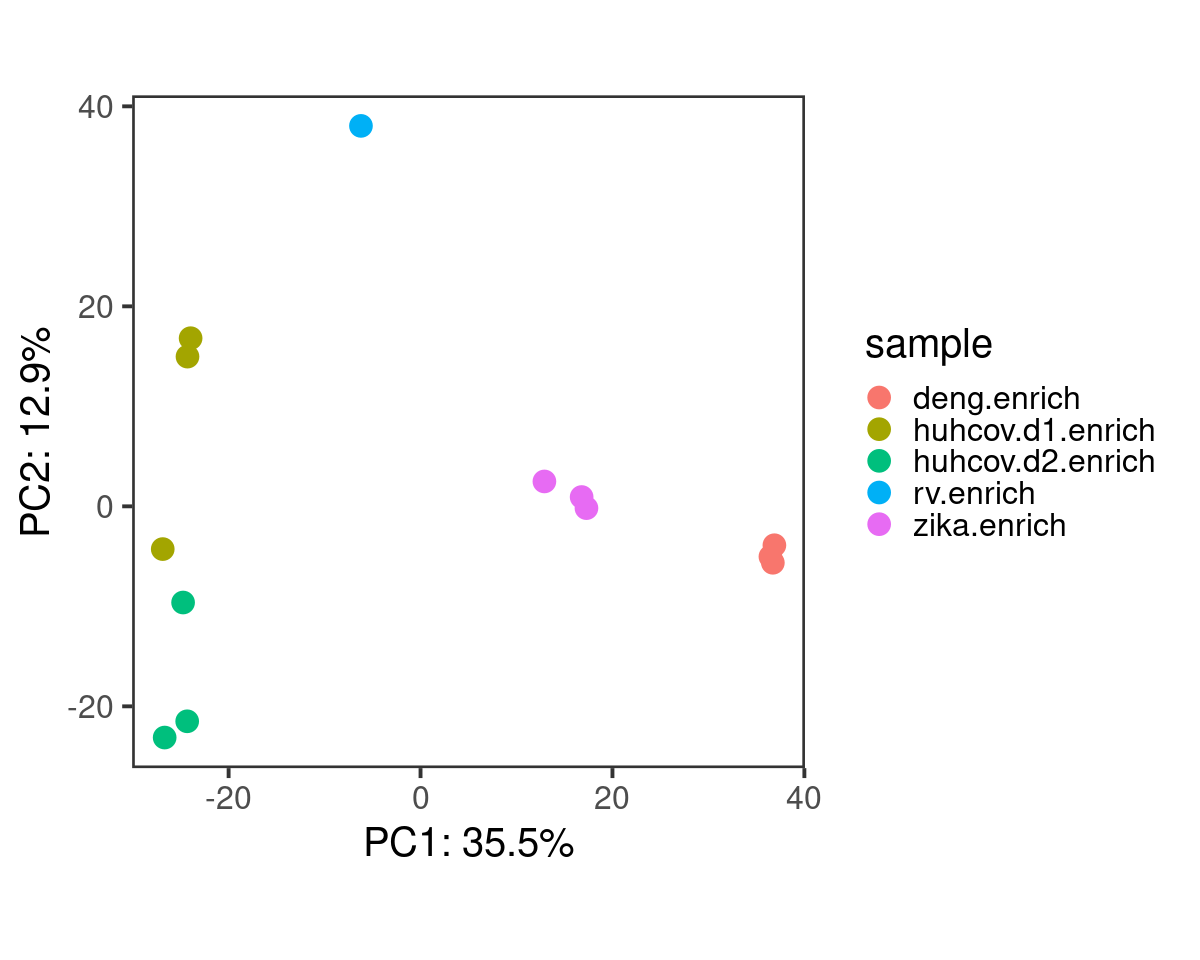

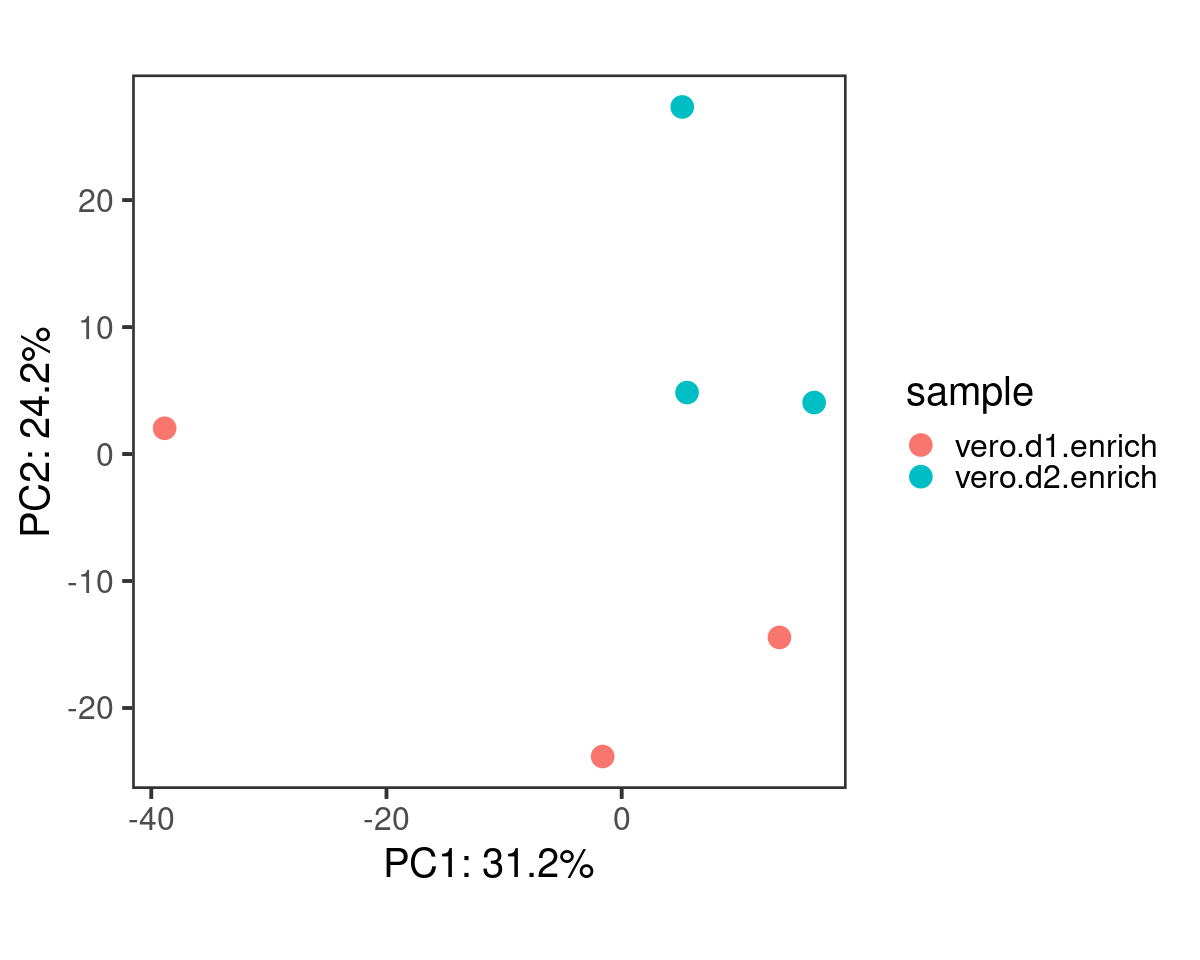

In [41]:
sel_cols <- function(df) {
    sel <- colnames(df)
    sel <- sel[grep("enrich",sel)]
    return(sel[which(!endsWith(sel,"mean"))])
}

pca_plt(huh_data,sel_cols(huh_data),nm = "huh-chirp",offset=2,corrout = chirp_outputs)
pca_plt(vero_data,sel_cols(vero_data),nm = "vero-chirp",offset=2,corrout = chirp_outputs)

In [42]:
everything <- merge(
    huh_data, vero_data,
    by.x = "name", by.y = "name", all.x=T, all.y=T
)

everything$huhd1_expanded <- everything$huhcov.d1.enrich.mean >= 1 & everything$species.x == "HUMAN"
everything$huhd2_expanded <- everything$huhcov.d2.enrich.mean >= 1 & everything$species.x == "HUMAN"
everything$verod1_expanded <- everything$vero.d1.enrich.mean >= 1 & everything$species.y == "CHLSB"
everything$verod2_expanded <- everything$vero.d2.enrich.mean >= 1 & everything$species.y == "CHLSB"

everything$huh_expanded <- everything$huhd1_expanded | everything$huhd2_expanded
everything$vero_expanded <- everything$verod1_expanded | everything$verod2_expanded
everything$sars_expanded <- everything$huh_expanded | everything$vero_expanded

everything$zika_expanded <- everything$zika.enrich.mean >= 1 & everything$species.x == "HUMAN"
everything$deng_expanded <- everything$deng.enrich.mean >= 1 & everything$species.x == "HUMAN"
everything$rv_expanded   <- everything$rv.enrich.1 >= 1 & everything$species.x == "HUMAN"

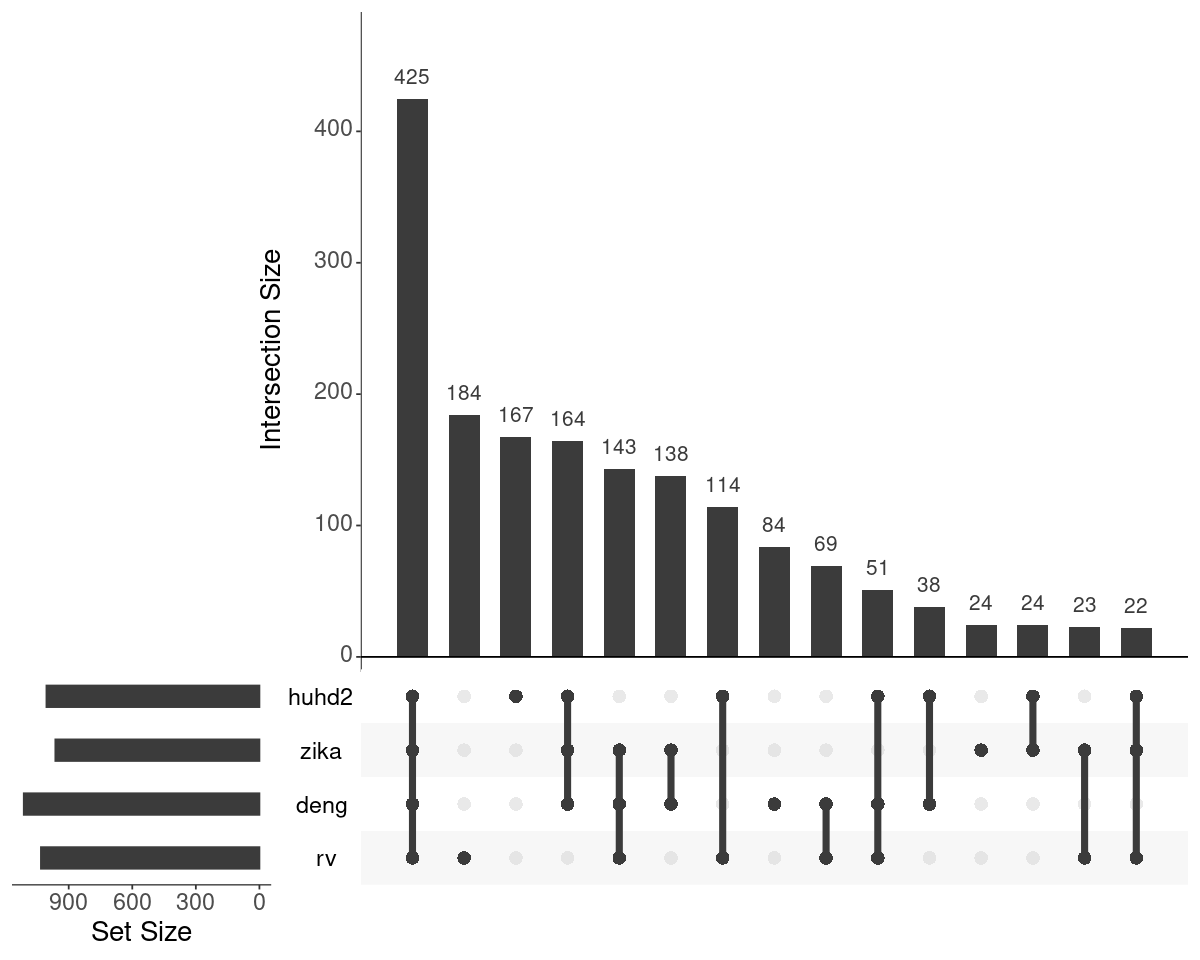

In [43]:
plt <- upset(
    fromList(list(
        #huhd1 = everything[which(everything$huhd1_expanded == T),"name"],
        huhd2 = everything[which(everything$huhd2_expanded == T),"name"],
        zika = everything[which(everything$zika_expanded == T),"name"],
        deng = everything[which(everything$deng_expanded == T),"name"],
        rv = everything[which(everything$rv_expanded == T),"name"]
    )), sets=rev(c("huhd2","zika","deng","rv")),
    order.by = "freq",
    point.size = 3.5, line.size = 2,text.scale=2,
    keep.order = TRUE
) 

plt

Warning message in if (is.na(genelist)) genelist <- df$name[which(startsWith(df$name, :
“条件的长度大于一，因此只能用其第一元素”


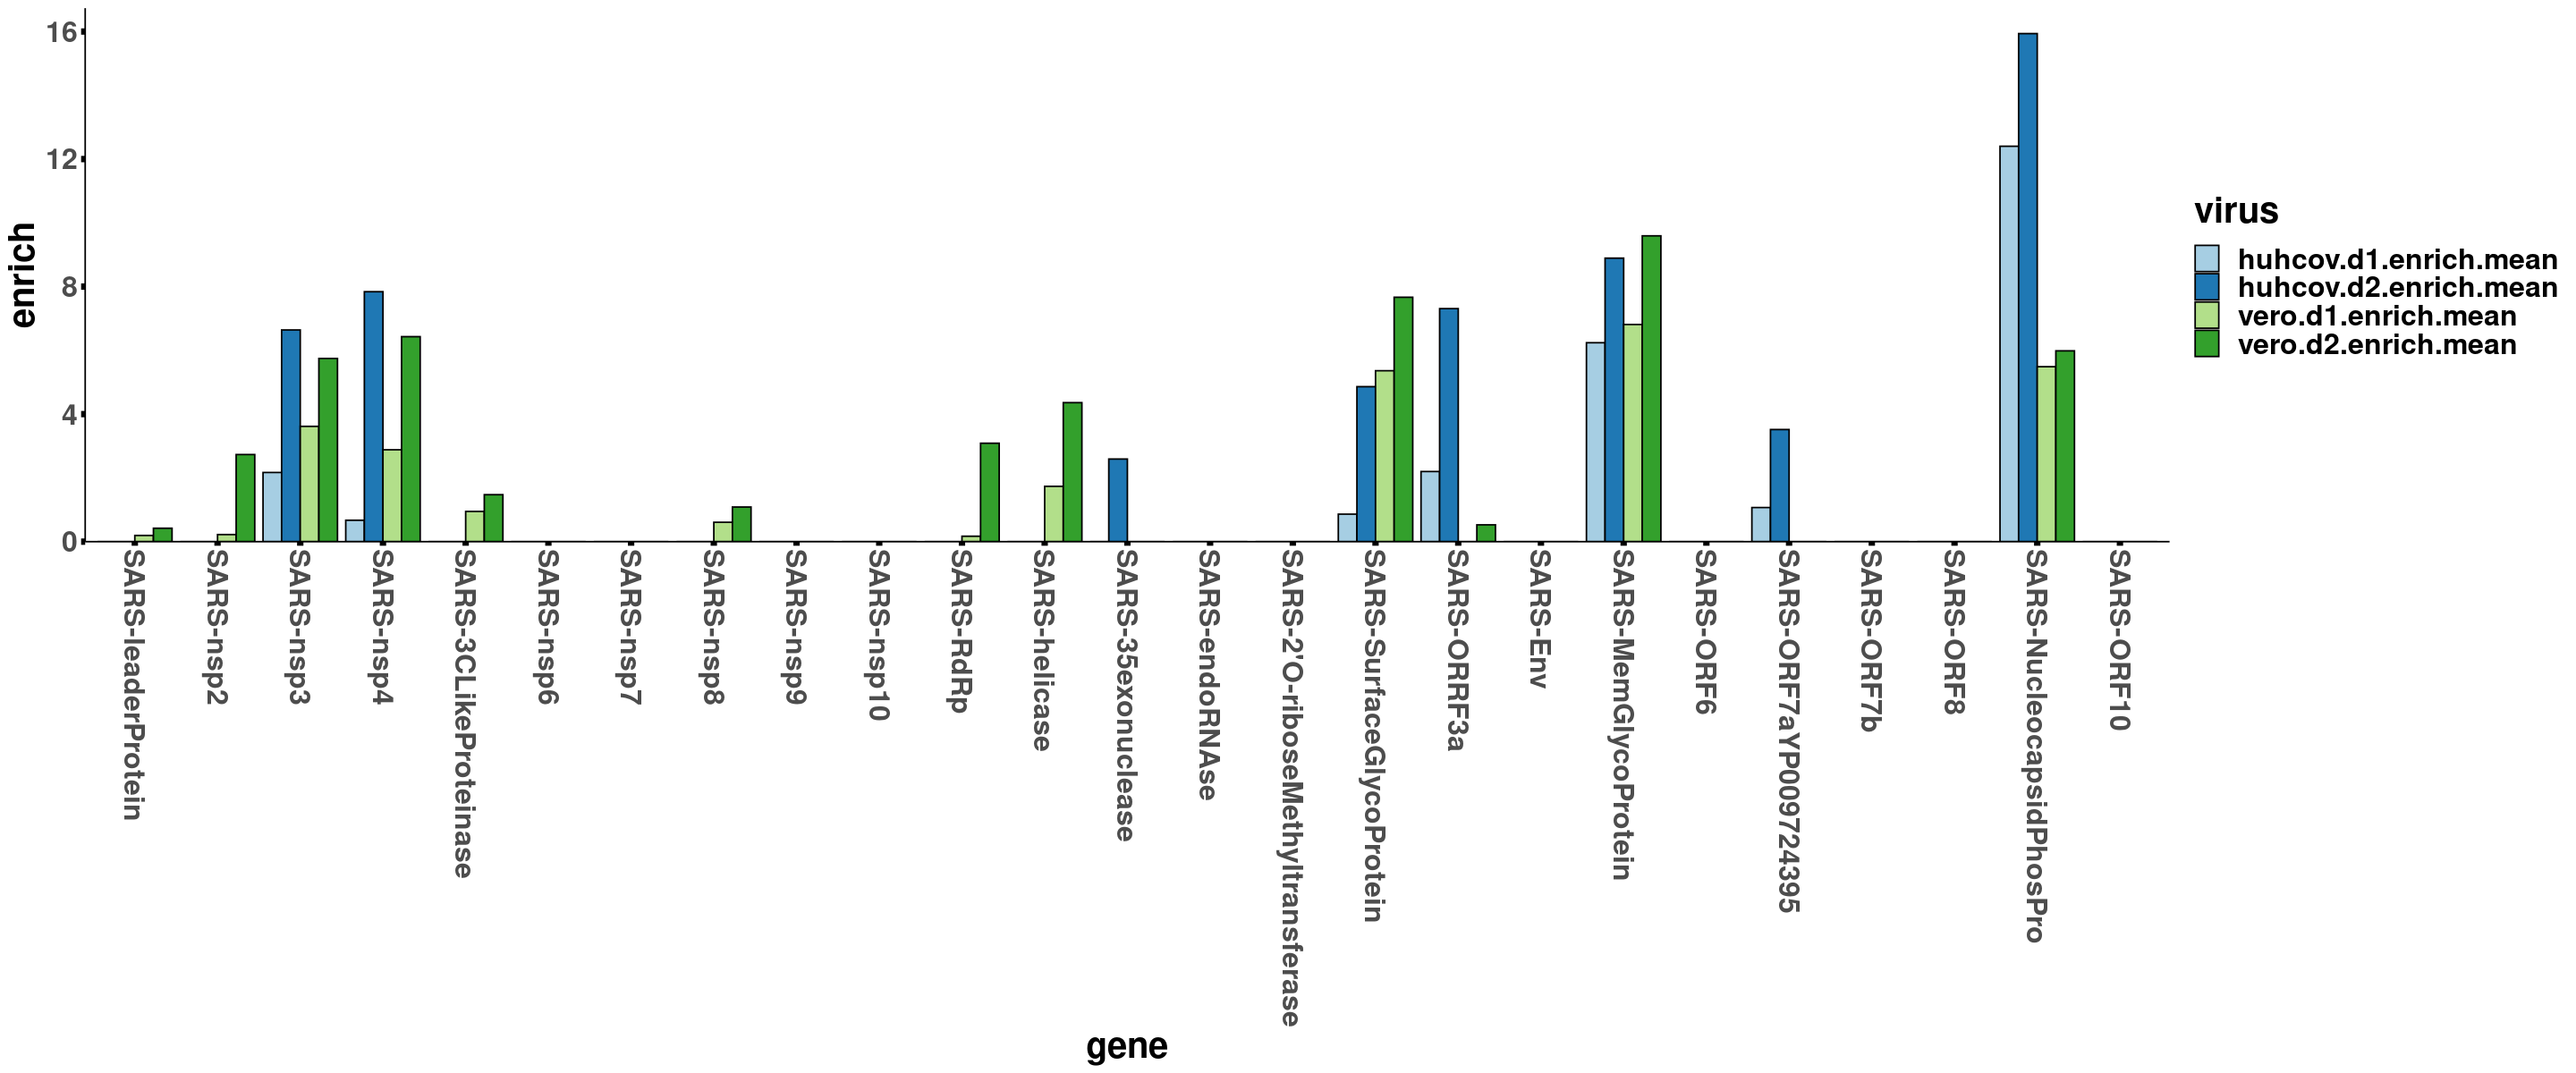

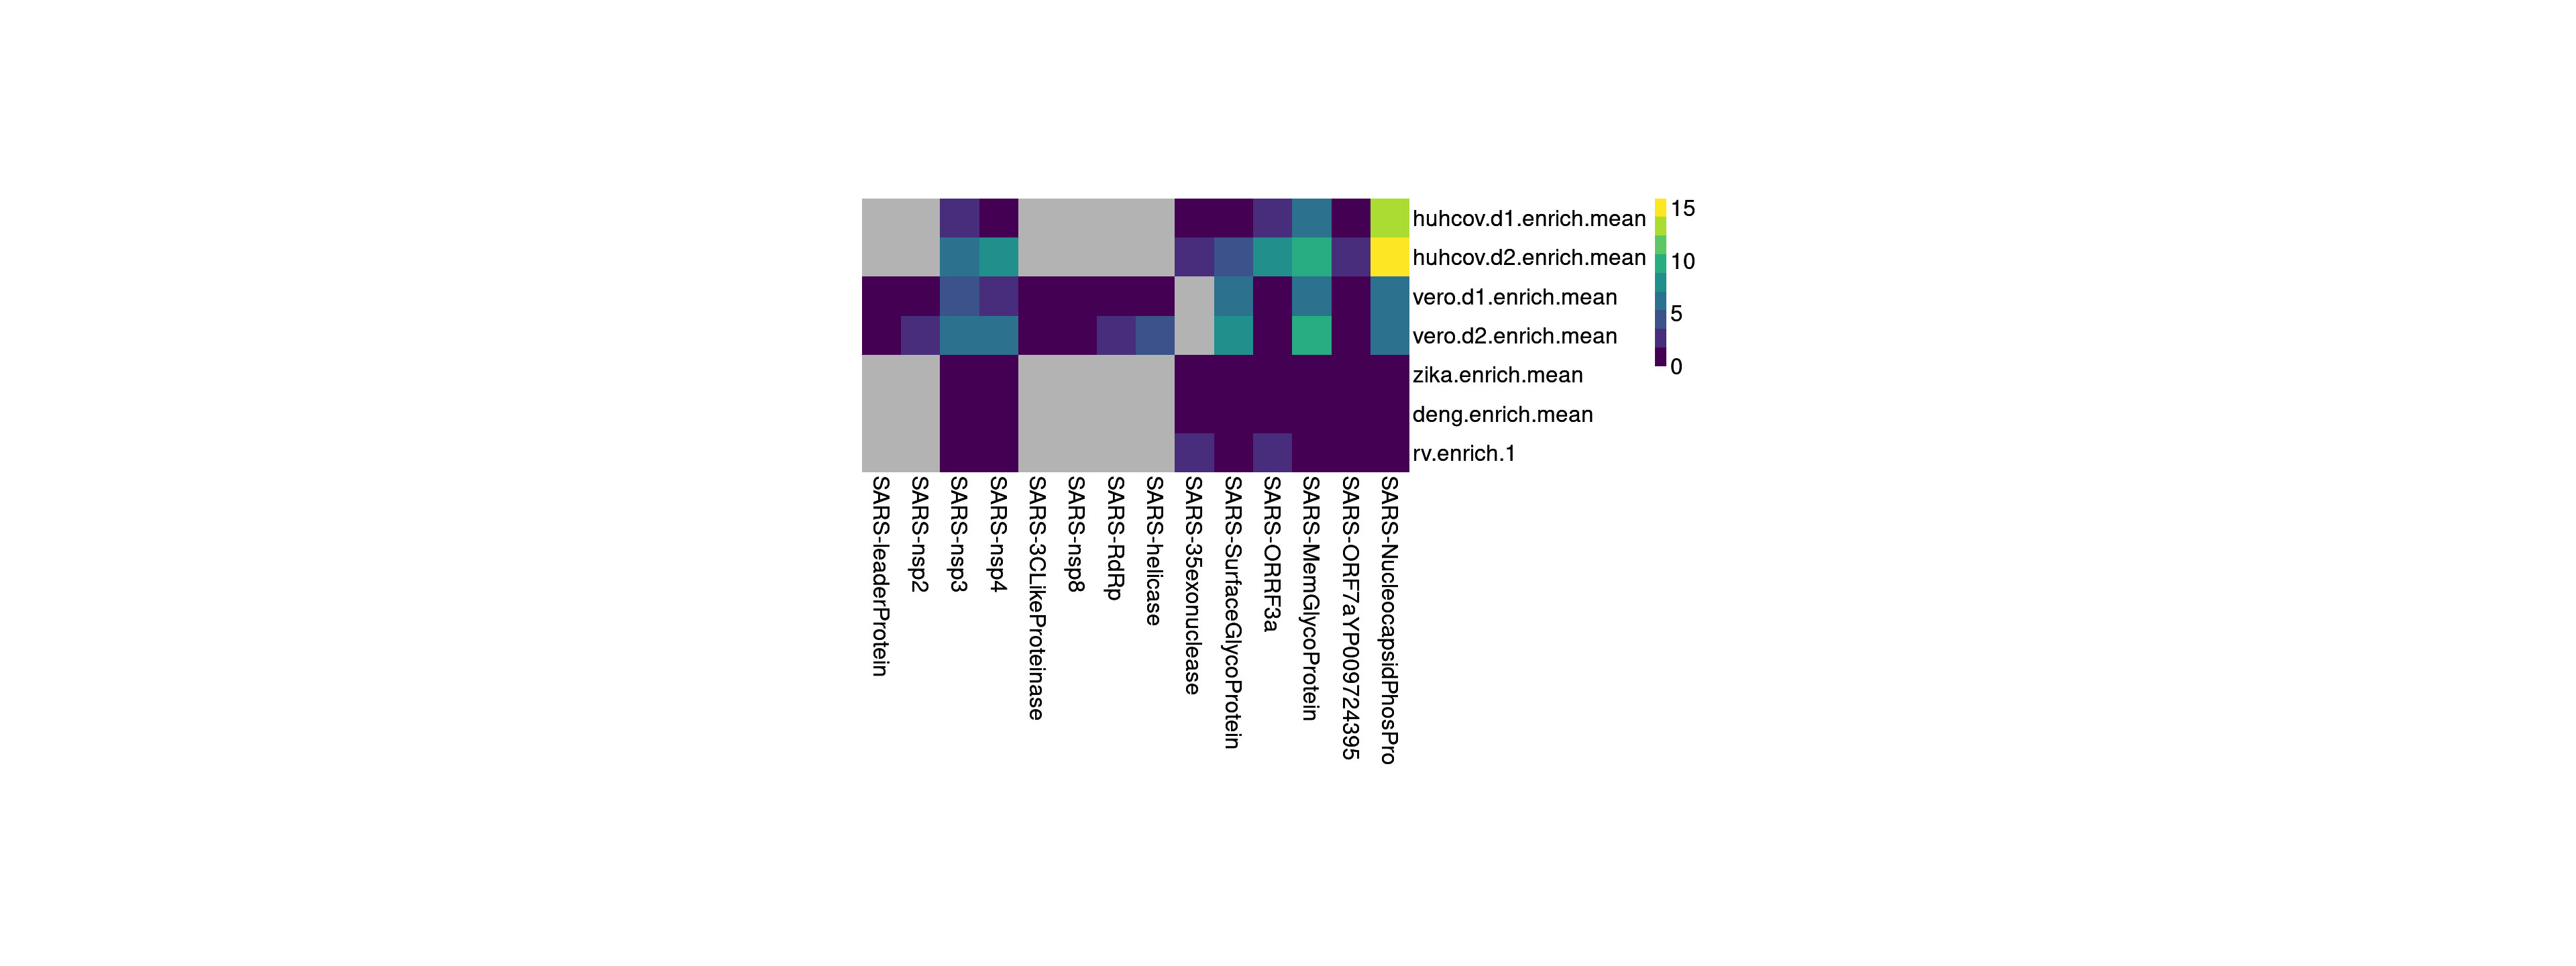

In [44]:

sarsfasta <- c(
    "SARS-leaderProtein",
    "SARS-nsp2",
    "SARS-nsp3",
    "SARS-nsp4",
    "SARS-3CLikeProteinase",
    "SARS-nsp6",
    "SARS-nsp7",
    "SARS-nsp8",
    "SARS-nsp9",
    "SARS-nsp10",
    "SARS-RdRp",
    "SARS-helicase",
    "SARS-35exonuclease",
    "SARS-endoRNAse",
    "SARS-2'O-riboseMethyltransferase",
    "SARS-SurfaceGlycoProtein",
    "SARS-ORRF3a",
    "SARS-Env",
    "SARS-MemGlycoProtein",
    "SARS-ORF6",
    "SARS-ORF7aYP009724395",
    "SARS-ORF7b",
    "SARS-ORF8",
    "SARS-NucleocapsidPhosPro",
    "SARS-ORF10"
)

make_bar_plot(everything,sw="viral_proteins",genelist = sarsfasta,fixord=T)
make_gene_set_heatmap(everything,sw="sars",colsel="allaverages",glist=sarsfasta,fixord=T,rmempty=F)